In [1]:
#Import all data
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np

In [2]:
# Load a binary classification dataset
scaler = StandardScaler()

data = pd.read_csv('train.csv')
X = data.drop("labels", axis=1)
print(X.shape)
y = data[["labels"]].copy()

X = scaler.fit_transform(X)

(5250, 1200)


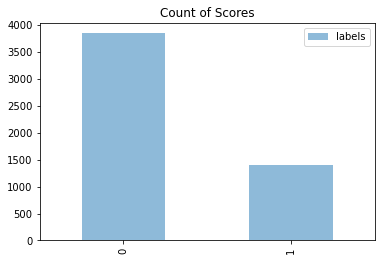

In [3]:
# Explore imbalance
import matplotlib.pyplot as plt
y['labels'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

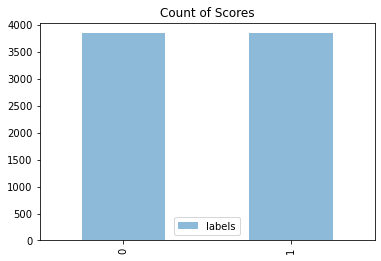

In [4]:
# Data sampling 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
over = SMOTE()
under = RandomUnderSampler()
X_o, y_o = over.fit_resample(X, y)

import matplotlib.pyplot as plt
y_o['labels'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

In [5]:
# Split data set and read test data

# X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_s, y_train_s = under.fit_resample(X_train, y_train)

X_ftest = pd.read_csv("test.csv")
X_ftest = X_ftest.drop("id", axis=1)
# Scale
X_ftest = scaler.fit_transform(X_ftest)
print(X_ftest.shape)

(2250, 1200)


In [6]:
# Use RFE for feature selection
# The estimator used for feature selection
rfe = RFE(LogisticRegression(solver='liblinear', max_iter=1000), n_features_to_select=1000)
X_train_s = rfe.fit_transform(X_train, y_train.to_numpy().ravel())
X_test_s = rfe.transform(X_test)

In [7]:
# Transform the true test data as well
# Use RFE for feature selection
rfe = RFE(LogisticRegression(solver='liblinear', max_iter=1000), n_features_to_select=1000)
X_s = rfe.fit_transform(X,  y.to_numpy().ravel())
X_ftest_s = rfe.transform(X_ftest)

In [8]:
# Create the individual classifiers with hyperparameters already tuned using pycaret
knn = KNeighborsClassifier(algorithm='auto', leaf_size=38, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                     weights='distance')
nb = GaussianNB(priors=None, var_smoothing=1)
lgbm  = LGBMClassifier(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=66, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=290, n_jobs=-1, num_leaves=70, objective=None,
               random_state=8623, reg_alpha=0.5, reg_lambda=0.01, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
svm = SVC()
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier(learning_rate=0.1, max_depth=7, min_child_weight=4, n_estimators=270)
bagging = BaggingClassifier(base_estimator=knn, n_estimators=10, random_state=42)


In [9]:
# Commented out code that I used for hyperparameter tuning before using pycaret

# # Define the parameter grids for KNN and Naive Bayes
# cv_method = RepeatedStratifiedKFold(n_splits=5, 
#                                     n_repeats=3, 
#                                     random_state=999)

# knn_param_grid = { 
#     'n_neighbors' : [5,7,9,11,13,15],
#     'weights' : ['uniform','distance'],
#     'metric' : ['minkowski','euclidean','manhattan'],
#     'leaf_size': [1,2,3]
# }

# nb_param_grid = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }

# # Optimize hyperparameters for KNN and Naive Bayes with early stopping

# knn_grid = GridSearchCV(estimator=knn, param_grid=knn_param_grid, scoring='f1', cv=cv_method, verbose=1, n_jobs=-1)
# knn_grid.fit(X_train, y_train.to_numpy().ravel())
# best_knn = knn_grid.best_estimator_

# nb_grid = GridSearchCV(estimator=nb, param_grid=nb_param_grid, scoring='f1', cv=cv_method, verbose=1, n_jobs=-1)
# nb_grid.fit(X_train, y_train.to_numpy().ravel())
# best_nb = nb_grid.best_estimator_

# print(knn_grid.best_params_)
# print(nb_grid.best_params_)

# Best so far
# {'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
# {'var_smoothing': 1.0}

# For oversampling
# {'leaf_size': 1, 'metric': 'minkowski', 'n_neighbors': 9, 'weights': 'distance'}
# {'var_smoothing': 0.657933224657568}

best_knn = knn
best_nb = nb

In [10]:
# Check against knn
best_knn.fit(X_train, y_train.to_numpy().ravel())

# Make predictions on test data
y_pred = best_knn.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

fscore = f1_score(y_test, y_pred)
print("fscore: {:.2f}%".format(fscore * 100))

Accuracy: 88.86%
fscore: 75.05%


In [11]:
# Check RFE against knn
best_knn.fit(X_train_s, y_train.to_numpy().ravel())

# Make predictions on test data
y_pred = best_knn.predict(X_test_s)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

fscore = f1_score(y_test, y_pred)
print("fscore: {:.2f}%".format(fscore * 100))

Accuracy: 89.43%
fscore: 76.13%


We Know RFE works and will use it for the rest of the testing

In [12]:
# # Create the ensemble voting model
# ensemble_model = VotingClassifier(estimators=[
#     ('knn', best_knn),
#     ('nb', best_nb),
#     ('xgb', xgb)
# ], voting='hard', n_jobs=-1)

# # Train the ensemble model
# ensemble_model.fit(X_train_s, y_train_s.to_numpy().ravel())

# # Make predictions on test data
# y_pred = ensemble_model.predict(X_test)

# # Evaluate the ensemble model
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: {:.2f}%".format(accuracy * 100))

# fscore = f1_score(y_test, y_pred)
# print("fscore: {:.2f}%".format(fscore * 100))

# Accuracy: 88.57%
# fscore: 75.61%

In [14]:
# Create the knn bagged model
bagging = BaggingClassifier(estimator=best_knn, n_estimators=20, random_state=42)

bagging.fit(X_train_s, y_train.to_numpy().ravel())
# Make predictions on test data
y_pred = bagging.predict(X_test_s)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

fscore = f1_score(y_test, y_pred)
print("fscore: {:.2f}%".format(fscore * 100))

Accuracy: 88.86%
fscore: 74.29%


In [16]:
# Create the ensemble model
ensemble_model = StackingClassifier(estimators=[
    ('knn', best_knn),
    ('nb', best_nb),
    ('xgb', xgb),
], final_estimator=best_knn)

# Train the ensemble model
ensemble_model.fit(X_train_s, y_train.to_numpy().ravel())

# Make predictions on test data
y_pred = ensemble_model.predict(X_test_s)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

fscore = f1_score(y_test, y_pred)
print("fscore: {:.2f}%".format(fscore * 100))


Accuracy: 88.29%
fscore: 75.74%


<Axes: >

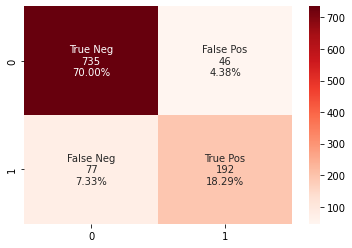

In [17]:
# Visualization
results = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')

In [19]:
# Get predicted probabilities for positive class
y_pred_proba = ensemble_model.predict_proba(X_test_s)[:, 1]

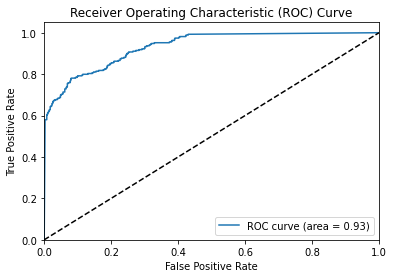

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

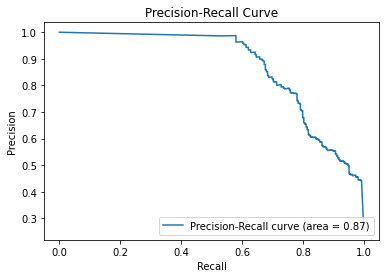

In [21]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

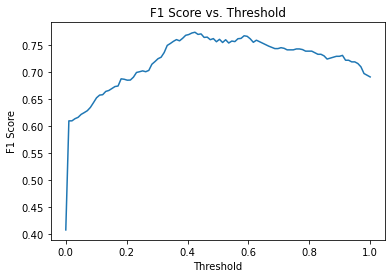

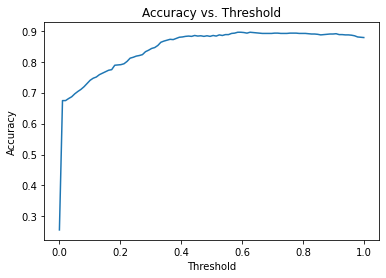

In [22]:
# Create an array of thresholds
thresholds = np.linspace(0, 1, 100)

# Calculate F1 scores and accuracies for different thresholds
f1_scores = [f1_score(y_test, y_pred_proba >= threshold) for threshold in thresholds]
accuracies = [accuracy_score(y_test, y_pred_proba >= threshold) for threshold in thresholds]

# Plot F1 Score vs. Threshold
plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.show()

# Plot Accuracy vs. Threshold
plt.figure()
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()

In [ ]:
#Pick which is better

In [27]:
#Train on actual data
ensemble_model = StackingClassifier(estimators=[
    ('knn', best_knn),
    ('nb', best_nb),
    ('xgb', xgb),
], final_estimator=best_knn)

# Train the ensemble model
ensemble_model.fit(X_s, y.to_numpy().ravel())
#Predict
y_pred = ensemble_model.predict(X_ftest_s)
print(y_pred)

[1 0 0 ... 1 0 1]


In [26]:
predict_df = pd.DataFrame(y_pred, columns=['labels'])
predict_df = predict_df.reset_index()
predict_df = predict_df.rename(columns={"index":"id"})
predict_df['id'] = predict_df.index + 1
predict_df.to_csv(r'submission_stacked_rfe.csv',index=False)

In [ ]:
# Ended up getting worse preformance with RFE and Standard Scale so my highest submission uses the same ensembled model without those 